In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

import time

# 1. **EDA и предобработка данных**

In [ ]:
data = pd.read_csv('loan_approval.csv')

Обзор содержащейся информации

In [ ]:
data.head(5)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


Датасет содержит следующие признаки:


*   person_age - возраст клиента
*   person_insome - доход клиента
* person_home_ownership - тип собственности клиента
* person_emp_length - стаж клиента
* loan_intent - цель кредита
* load_grade - грэйд кредита
* loan_amnt - сумма кредита
* loan_int_rate - процентная ставка по кредиту
* loan_percent_income - процентный доход по кредиту
* cb_person_cred_hist_length - длина кредитной истории
* loan_status - целевая переменная



Основные характеристики данных

In [ ]:
data.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [ ]:
data.drop('id', axis = 1, inplace = True)

Посмотрим корреляцию с целевой переменной и графики основных зависимостей

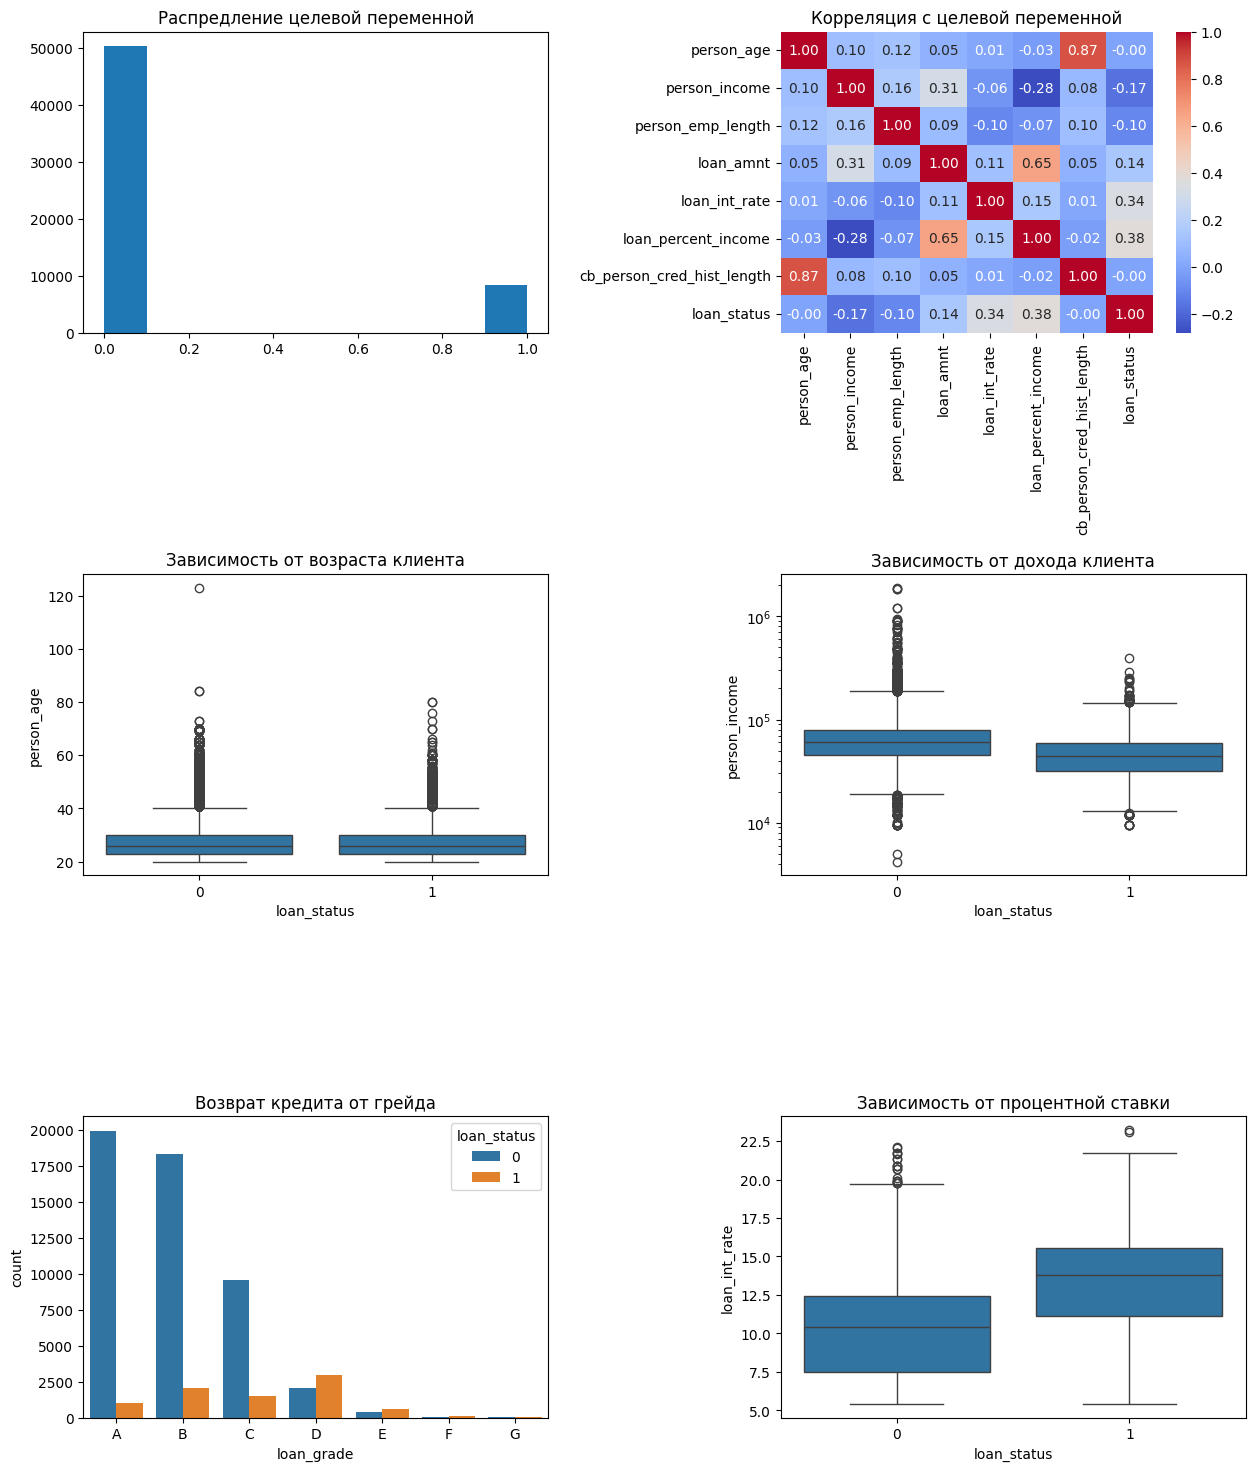

In [ ]:
fig, axs = plt.subplots(3, 2, figsize = (15, 18))
plt.subplots_adjust(hspace=0.8, wspace=0.5)

#1. Распредление целевой переменной
axs[0,0].hist(data['loan_status'])
axs[0,0].set_title('Распредление целевой переменной')

#2. Корреляция с целевой переменной
data_corr = data.select_dtypes(exclude = 'object').corr()
sns.heatmap(data_corr, annot = True, cmap = 'coolwarm', fmt = '.2f', ax = axs[0, 1])
axs[0, 1].set_title('Корреляция с целевой переменной')

#3. Возврат кредита в зависимости от возраста
x3 = data['loan_status']
y3 = data['person_age']
sns.boxplot(x = x3, y = y3, ax = axs[1, 0])
axs[1, 0].set_title('Зависимость от возраста клиента')

#4.  Возврат кредита в зависимости от дохода
x4 = data['loan_status']
y4 = data['person_income']
axs[1, 1].set_yscale('log')
sns.boxplot(x = x4, y = y4, ax = axs[1, 1])
axs[1, 1].set_title('Зависимость от дохода клиента')

#5. Возврат кредита от грейда
sns.countplot(x = data['loan_grade'], hue = data['loan_status'],  ax = axs[2, 0], order = sorted(data['loan_grade'].unique()))
axs[2, 0].set_title('Возврат кредита от грейда')

#6. Возврат кредита в зависимости от процентной ставки
x6 = data['loan_status']
y6 = data['loan_int_rate']
sns.boxplot(x = x6, y = y6, ax = axs[2, 1])
axs[2, 1].set_title('Зависимость от процентной ставки')

plt.show()

1. Целевая переменная не сбалансирована
2. По второму графику видно, что наиболее скоррелированные с таргетом переменные - это loan_int_rate и loan_percent_income.
3. По третьему - что медианный возраст заемщиков примерно одинаков для тех, кто возвращает кредит и кто - нет
4. Клиенты сильно различаются по уровню дохода. Клиенты с более высоким доходом чаще не возвращают кредит.
5. Чем выше грейд, тем больше клиентов не вернут кредит.
6. Чем выше ставка - тем реже возвращают кредиты, что логично, так как больше риски.

Пропущенных значений нет

In [ ]:
data.sum().isna()

,0
person_age,False
person_income,False
person_home_ownership,False
person_emp_length,False
loan_intent,False
loan_grade,False
loan_amnt,False
loan_int_rate,False
loan_percent_income,False
cb_person_default_on_file,False


Посмотрим на категориальные признаки

In [ ]:
data.dtypes

,0
person_age,int64
person_income,int64
person_home_ownership,object
person_emp_length,float64
loan_intent,object
loan_grade,object
loan_amnt,int64
loan_int_rate,float64
loan_percent_income,float64
cb_person_default_on_file,object


Переменные loan_grade и cb_person_default_on_file порядковые, к ним можно применить LabelEncoder, к остальным - OneHotEncoder

In [ ]:
ohe = OneHotEncoder()
ohe.fit(data[['person_home_ownership', 'loan_intent']])

OneHotEncoder()

In [ ]:
codes = ohe.transform(data[['person_home_ownership', 'loan_intent']]).toarray()
codes

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [ ]:
feature_names = ohe.get_feature_names_out()
feature_names

array(['person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE'], dtype=object)

In [ ]:
data = pd.concat([data.drop(labels = ['person_home_ownership', 'loan_intent'], axis = 1), pd.DataFrame(codes, columns = feature_names)], axis = 1)

In [ ]:
le = LabelEncoder()
data['loan_grade'] = le.fit_transform(data['loan_grade'])
data['cb_person_default_on_file'] = le.fit_transform(data['cb_person_default_on_file'])

In [ ]:
data.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,37,35000,0.0,1,6000,11.49,0.17,0,14,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,22,56000,6.0,2,4000,13.35,0.07,0,2,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,29,28800,8.0,0,6000,8.90,0.21,0,10,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,30,70000,14.0,1,12000,11.11,0.17,0,5,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,22,60000,2.0,0,6000,6.92,0.10,0,3,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# 2. **Обучение классических моделей ML**

Подготовим данные

In [ ]:
X = data.drop('loan_status', axis = 1)
y = data['loan_status']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

Базовые ML модели

In [ ]:
base_models = {
  #tree-based models
  'Random Forest': RandomForestClassifier(n_estimators = 100, random_state = 42),
  'Decision Tree': DecisionTreeClassifier(max_depth = 10, random_state = 42),

  # linear models
  'Logistic Regression': LogisticRegression(max_iter = 1000, random_state = 42),

  # distance-based models
  'KNN': KNeighborsClassifier(n_neighbors = 5),
  'SVC': SVC(kernel = 'linear', probability = True, random_state = 42),

  #gradient boosting
  'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
        random_state=42, eval_metric='logloss', verbosity=0),
  'LightGBM': lgb.LGBMClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1,
        random_state=42, verbosity=-1, force_col_wise=True)
  }

Обучим модели

In [ ]:
base_result = {}
base_prediction = {}
for name in base_models.keys():
  start_time = time.time()
  print(f'✅ Обучение {name}')
  #Проверим, нужно ли модели скалирование
  if name in ['Logistic Regression', 'KNN', 'SVC']:
    X_train_cur = X_train_scaled
    X_test_cur = X_test_scaled
  else:
    X_train_cur = X_train
    X_test_cur = X_test

  #Обучим модель
  base_models[name].fit(X_train_cur, y_train)

  #Получим предсказание
  y_pred = base_models[name].predict(X_test_cur)
  y_pred_proba = base_models[name].predict_proba(X_test_cur)[:, 1]

  #Cross-validation
  cv = cross_val_score(base_models[name], X_train_cur, y_train, cv = 5, scoring = 'roc_auc')
  train_time = time.time() - start_time
  #Запишем результаты
  base_result[name] = {
      'model': base_models[name],
      'accuracy': accuracy_score(y_test, y_pred),
      'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
      'CV score': cv.mean(),
      'Training time': train_time
  }
  base_prediction[name] = y_pred_proba

  print(f'Accuracy = {base_result[name]["accuracy"]:.4f}')
  print(f'ROC-AUC = {base_result[name]["ROC-AUC"]:.4f}')
  print(f'CV score = {base_result[name]["CV score"]:.4f}')
  print(f'Время обучения {base_result[name]["Training time"]:.2f} сек')

#Сравнительная таблица
base_df = pd.DataFrame({
    'Model': list(base_result.keys()),
    'ROC-AUC': [base_result[name]['ROC-AUC'] for name in base_result.keys()],
    'Accuracy': [base_result[name]['accuracy'] for name in base_result.keys()],
    'CV score': [base_result[name]['CV score'] for name in base_result.keys()],
    'Training time': [base_result[name]['Training time'] for name in base_result.keys()]
})
base_df = base_df.sort_values('ROC-AUC', ascending = False).reset_index(drop = True)
print(f'{"-"*80}')
print('⚡ Сравнение моделей')
print(base_df.round(4).to_string(index = False))

✅ Обучение Random Forest
Accuracy = 0.9514
ROC-AUC = 0.9316
CV score = 0.9352
Время обучения 50.18 сек
✅ Обучение Decision Tree
Accuracy = 0.9481
ROC-AUC = 0.9087
CV score = 0.9083
Время обучения 1.22 сек
✅ Обучение Logistic Regression
Accuracy = 0.9016
ROC-AUC = 0.8968
CV score = 0.8923
Время обучения 2.70 сек
✅ Обучение KNN
Accuracy = 0.9310
ROC-AUC = 0.8682
CV score = 0.8773
Время обучения 19.87 сек
✅ Обучение SVC
Accuracy = 0.9008
ROC-AUC = 0.8935
CV score = 0.8890
Время обучения 1251.00 сек
✅ Обучение XGBoost
Accuracy = 0.9519
ROC-AUC = 0.9539
CV score = 0.9528
Время обучения 3.38 сек
✅ Обучение LightGBM
Accuracy = 0.9517
ROC-AUC = 0.9568
CV score = 0.9543
Время обучения 5.08 сек
--------------------------------------------------------------------------------
⚡ Сравнение моделей
              Model  ROC-AUC  Accuracy  CV score  Training time
           LightGBM   0.9568    0.9517    0.9543         5.0804
            XGBoost   0.9539    0.9519    0.9528         3.3810
      Random 

LightGBM и XGBoost показали самые лучшие результаты по ROC-AUC

Визуализируем результаты для базовых моделей

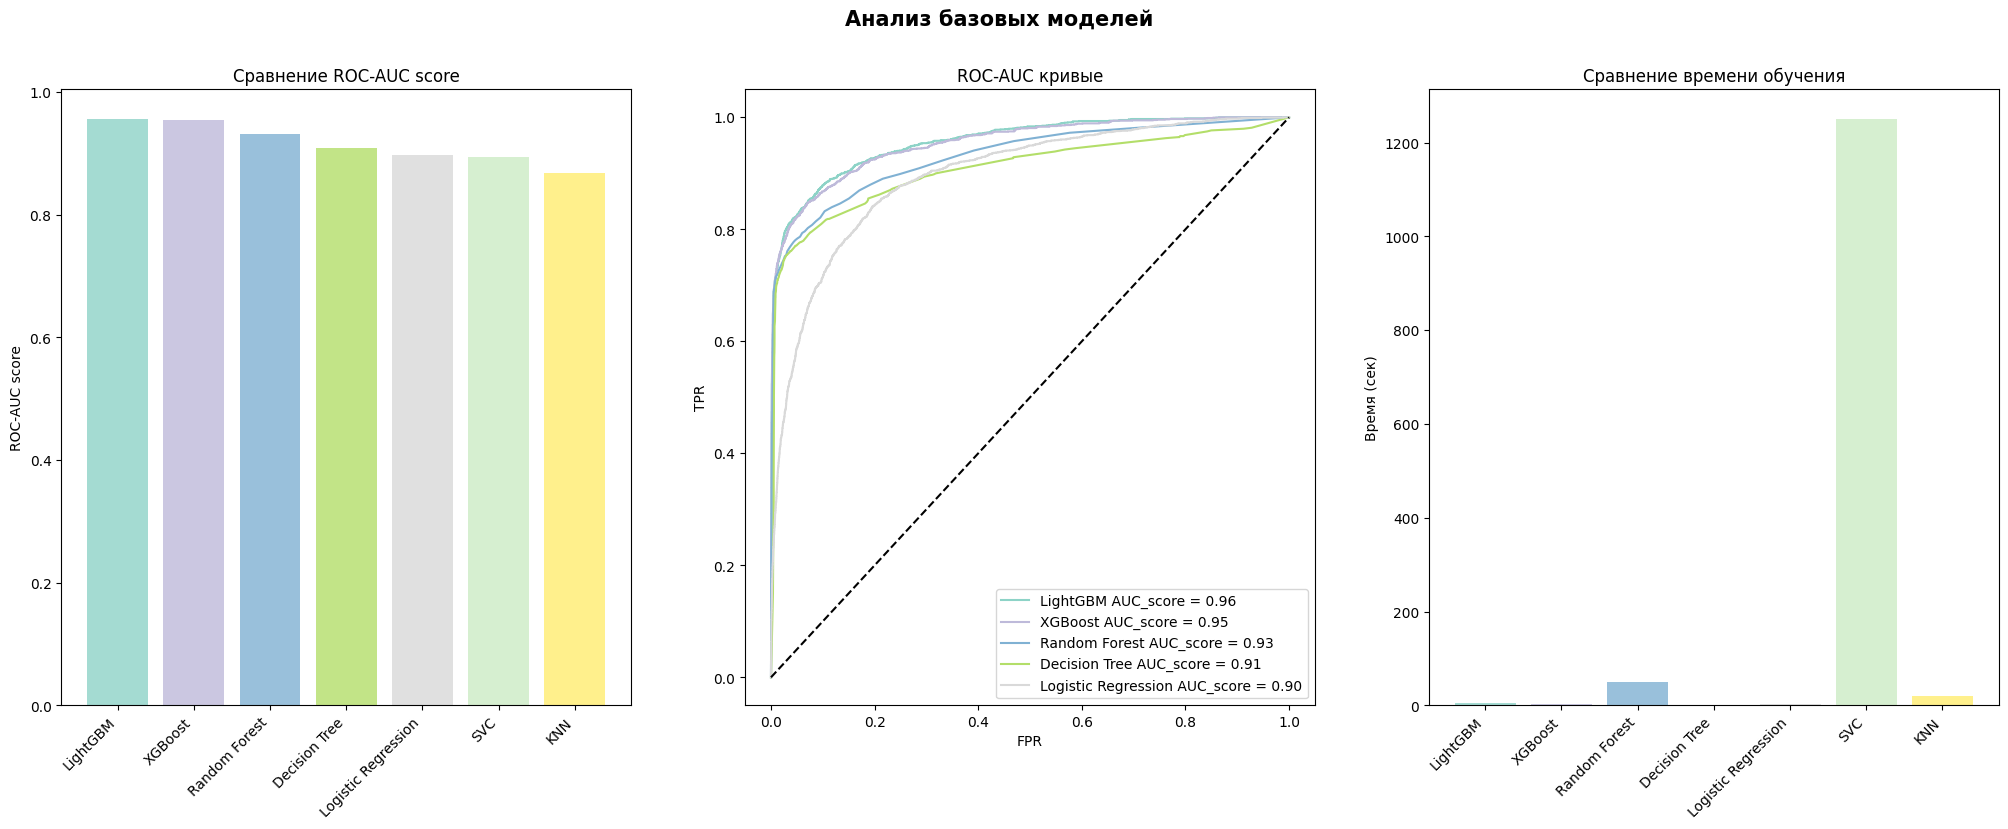

In [ ]:
fg, axs = plt.subplots(1, 3, figsize = (25, 8))

#ROC-AUC
colors = plt.cm.Set3(np.linspace(0, 1, len(base_df)))
axs[0].bar(range(len(base_df['Model'])), base_df['ROC-AUC'], color = colors, alpha = 0.8)
axs[0].set_xticks(range(len(base_df['Model'])))
axs[0].set_xticklabels(base_df['Model'], rotation = 45, ha = 'right')
axs[0].set_ylabel('ROC-AUC score')
axs[0].set_title('Сравнение ROC-AUC score')

# ROC-AUC кривые для 5 лучших моделей
best_models = base_df.head(5)['Model'].tolist()
for i, name in enumerate(best_models):
  fpr, tpr, _ = roc_curve(y_test, base_prediction[name])
  auc_score = base_result[name]['ROC-AUC']
  axs[1].plot(fpr, tpr, label = f'{name} AUC_score = {auc_score:.2f}', color = colors[i])
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_xlabel('FPR')
axs[1].set_ylabel('TPR')
axs[1].legend()
axs[1].set_title('ROC-AUC кривые')

#Время обучения моделей
axs[2].bar(base_df['Model'], base_df['Training time'], color = colors, alpha = 0.8)
axs[2].set_xticks(range(len(base_df)))
axs[2].set_xticklabels(base_df['Model'], rotation = 45, ha = 'right')
axs[2].set_ylabel('Время (сек)')
axs[2].set_title('Сравнение времени обучения')

plt.suptitle('Анализ базовых моделей', fontsize = 15, fontweight = 'bold')
plt.show()

Видно, что все модели показали хороший ROC-AUC. SVC обучалась кратно дольше, чем остальные модели, и у нее одна из самых низких ROC-AUC. Так что дальше уберем ее и KNN из рассмотрения

**Подберем гиперпараметры с помощью Optuna**

In [ ]:
def optimizeLightGBM(trial, X_train, y_train):
  params = {
      'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
      'max_depth': trial.suggest_int('max_depth', 3, 10),
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
      'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
      'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
      'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
      'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
      'verbosity': -1,
      'random_state': 42
  }
  model = lgb.LGBMClassifier(**params)
  cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'roc_auc')
  return cv_scores.mean()

def optimizeXGBoost(trial, X_train, y_train):
  params = {
      'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
      'max_depth': trial.suggest_int('max_depth', 3, 10),
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
      'subsample': trial.suggest_float('subsample', 0.6, 1.0),
      'colsample_bytree': trial.suggest_float('bagging_fraction', 0.6, 1.0),
      'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
      'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
      'verbosity': 0,
      'random_state': 42
  }
  model = xgb.XGBClassifier(**params)
  cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'roc_auc')
  return cv_scores.mean()

def optimizeRandomForest(trial, X_train, y_train):
  params = {
      'n_estimators': trial.suggest_int('n_estimators', 50, 250),
      'max_depth': trial.suggest_int('max_depth', 3, 20),
      'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
      'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
      'random_state': 42
  }
  model = RandomForestClassifier(**params)
  cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'roc_auc')
  return cv_scores.mean()

def optimizeDecisionTree(trial, X_train, y_train):
  params = {
      'max_depth': trial.suggest_int('max_depth', 3, 20),
      'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
      'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
      'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt', None]),
      'random_state': 42
  }
  model = DecisionTreeClassifier(**params)
  cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'roc_auc')
  return cv_scores.mean()

def optimizeLogisticRegression(trial, X_train, y_train):
  params = {
        'C': trial.suggest_float('C', 0.01, 100, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'max_iter': 2000,
        'random_state': 42
    }

    # Для elasticnet нужен l1_ratio
  if params['penalty'] == 'elasticnet':
      params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)
      params['solver'] = 'saga'  # только saga поддерживает elasticnet

    # liblinear не поддерживает elasticnet
  if params['penalty'] == 'elasticnet' and params['solver'] == 'liblinear':
      params['solver'] = 'saga'

  model = LogisticRegression(**params)
  scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
  return scores.mean()

In [ ]:
opt_models = {
    'LightGBM': optimizeLightGBM,
    'XGBoost': optimizeXGBoost,
    'Random Forest': optimizeRandomForest,
    'Decision Tree': optimizeDecisionTree,
    'Logistic Regression': optimizeLogisticRegression
}

In [ ]:
import optuna
from optuna.samplers import TPESampler

N_TRIALS = 100
TIMEOUT = 300

opt_result = {}

for name, func in opt_models.items():
  print(f'✅Оптимизируем {name}...')
  start_time = time.time()

  if name in ['Logistic Regression']:
    X_train_cur = X_train_scaled
    X_test_cur = X_test_scaled
  else:
    X_train_cur = X_train
    X_test_cur = X_test
  #Оптимизируем
  study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = 42))
  study.optimize(lambda trial: func(trial, X_train_cur, y_train), n_trials = N_TRIALS, timeout = TIMEOUT, show_progress_bar = False)

  #Обучаем модель на лучших параметрах
  if name == 'LightGBM':
    model = lgb.LGBMClassifier(**study.best_params)
  elif name == 'XGBoost':
    model = xgb.XGBClassifier(**study.best_params)
  elif name == 'Random Forest':
    model = RandomForestClassifier(**study.best_params)
  elif name == 'Decision Tree':
    model = DecisionTreeClassifier(**study.best_params)
  elif name == 'Logistic Regression':
    model = LogisticRegression(**study.best_params)

  model.fit(X_train_cur, y_train)
  y_pred = model.predict(X_test_cur)
  y_pred_proba = model.predict_proba(X_test_cur)[:, 1]

  cv_score_opt = cross_val_score(model, X_train_cur, y_train, cv = 5, scoring = 'roc_auc')

  opt_time = time.time() - start_time

  opt_result[name] = {
      'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
      'Accuracy': accuracy_score(y_test, y_pred),
      'CV score': cv_score_opt.mean(),
      'Optim time': opt_time,
      'Best params': study.best_params
  }
  #Выведем результаты после оптимизации
  print(f'ROC-AUC {opt_result[name]["ROC-AUC"]:.4f}')
  print(f'Accuracy {opt_result[name]["Accuracy"]:.4f}')
  print(f'CV score {opt_result[name]["CV score"]:.4f}')
  print(f'Время оптимизации {opt_result[name]["Optim time"]:.4f} сек')


[I 2025-08-18 17:26:04,496] A new study created in memory with name: no-name-82a67851-7118-45d2-bfd1-ff81a91652c6


✅Оптимизируем LightGBM...


[I 2025-08-18 17:26:23,249] Trial 0 finished with value: 0.9547274550294281 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'min_child_samples': 19, 'reg_alpha': 0.5808361216819946, 'reg_lambda': 8.661761457749352}. Best is trial 0 with value: 0.9547274550294281.
[I 2025-08-18 17:26:42,653] Trial 1 finished with value: 0.9546402162558063 and parameters: {'n_estimators': 641, 'max_depth': 8, 'learning_rate': 0.01596950334578271, 'feature_fraction': 0.9879639408647978, 'bagging_fraction': 0.9329770563201687, 'min_child_samples': 25, 'reg_alpha': 1.8182496720710062, 'reg_lambda': 1.8340450985343382}. Best is trial 0 with value: 0.9547274550294281.
[I 2025-08-18 17:26:53,160] Trial 2 finished with value: 0.9568987420928791 and parameters: {'n_estimators': 374, 'max_depth': 7, 'learning_rate': 0.13526405540621358, 'feature_fraction': 0.7164916560792167, 'bagging_fract

ROC-AUC 0.9586
Accuracy 0.9523
CV score 0.9572
Время оптимизации 329.7519 сек
✅Оптимизируем XGBoost...


[I 2025-08-18 17:31:56,656] Trial 0 finished with value: 0.9473594293834593 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 1.5227525095137953}. Best is trial 0 with value: 0.9473594293834593.
[I 2025-08-18 17:32:25,853] Trial 1 finished with value: 0.9491459055274379 and parameters: {'n_estimators': 880, 'max_depth': 7, 'learning_rate': 0.21534104756085318, 'subsample': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.9110519961044856}. Best is trial 1 with value: 0.9491459055274379.
[I 2025-08-18 17:32:33,360] Trial 2 finished with value: 0.9534896473569272 and parameters: {'n_estimators': 263, 'max_depth': 4, 'learning_rate': 0.09823025045826593, 'subsample': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'reg_alpha': 2.9122914019804194, 'reg_lambda':

ROC-AUC 0.9573
Accuracy 0.9528
CV score 0.9557
Время оптимизации 344.5509 сек
✅Оптимизируем Random Forest...


[I 2025-08-18 17:37:52,164] Trial 0 finished with value: 0.93997475825109 and parameters: {'n_estimators': 125, 'max_depth': 20, 'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 3}. Best is trial 0 with value: 0.93997475825109.
[I 2025-08-18 17:38:40,695] Trial 1 finished with value: 0.9394140305277497 and parameters: {'n_estimators': 224, 'max_depth': 13, 'criterion': 'log_loss', 'min_samples_leaf': 9, 'min_samples_split': 6}. Best is trial 0 with value: 0.93997475825109.
[I 2025-08-18 17:38:51,460] Trial 2 finished with value: 0.9269819455805534 and parameters: {'n_estimators': 86, 'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 3, 'min_samples_split': 13}. Best is trial 0 with value: 0.93997475825109.
[I 2025-08-18 17:39:03,611] Trial 3 finished with value: 0.9334618412292365 and parameters: {'n_estimators': 78, 'max_depth': 8, 'criterion': 'log_loss', 'min_samples_leaf': 2, 'min_samples_split': 11}. Best is trial 0 with value: 0.93997475825109.
[I 2025-0

ROC-AUC 0.9378
Accuracy 0.9515
CV score 0.9408
Время оптимизации 390.2938 сек
✅Оптимизируем Decision Tree...


[I 2025-08-18 17:43:50,008] Trial 0 finished with value: 0.9195293472551681 and parameters: {'max_depth': 9, 'criterion': 'gini', 'min_samples_leaf': 6, 'min_samples_split': 4, 'max_features': None}. Best is trial 0 with value: 0.9195293472551681.
[I 2025-08-18 17:43:50,338] Trial 1 finished with value: 0.902250926240928 and parameters: {'max_depth': 13, 'criterion': 'gini', 'min_samples_leaf': 10, 'min_samples_split': 17, 'max_features': 'log2'}. Best is trial 0 with value: 0.9195293472551681.
[I 2025-08-18 17:43:51,137] Trial 2 finished with value: 0.920475301080763 and parameters: {'max_depth': 8, 'criterion': 'gini', 'min_samples_leaf': 3, 'min_samples_split': 13, 'max_features': None}. Best is trial 2 with value: 0.920475301080763.
[I 2025-08-18 17:43:51,434] Trial 3 finished with value: 0.9064025005404679 and parameters: {'max_depth': 11, 'criterion': 'gini', 'min_samples_leaf': 6, 'min_samples_split': 13, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.920475301080763.
[I

ROC-AUC 0.9233
Accuracy 0.9506
CV score 0.9208
Время оптимизации 82.1484 сек
✅Оптимизируем Logistic Regression...


[I 2025-08-18 17:45:20,401] Trial 0 finished with value: 0.9010572008147452 and parameters: {'C': 0.31489116479568624, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.9010572008147452.
[I 2025-08-18 17:45:21,861] Trial 1 finished with value: 0.9006948669843804 and parameters: {'C': 0.017073967431528128, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 0 with value: 0.9010572008147452.
[I 2025-08-18 17:45:23,495] Trial 2 finished with value: 0.9010998292863013 and parameters: {'C': 21.368329072358772, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 2 with value: 0.9010998292863013.
[I 2025-08-18 17:45:24,957] Trial 3 finished with value: 0.9010572008147452 and parameters: {'C': 0.5342937261279778, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 2 with value: 0.9010998292863013.
[I 2025-08-18 17:45:43,523] Trial 4 finished with value: 0.90103588521599 and parameters: {'C': 0.6672367170464207, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 2 with value:

ROC-AUC 0.8969
Accuracy 0.9019
CV score 0.8924
Время оптимизации 203.2948 сек


Сравним результаты ДО и ПОСЛЕ оптимизации

In [ ]:
comparison_result = []
for name in base_result.keys():
  if name not in ['SVC', 'KNN']:
  #Before optimization
    before_roc = base_result[name]['ROC-AUC']
    before_accuracy = base_result[name]['accuracy']
    before_cv_score = base_result[name]['CV score']

  #After optimization
    after_roc = opt_result[name]['ROC-AUC']
    after_accuracy = opt_result[name]['Accuracy']
    after_cv_score = opt_result[name]['CV score']

  #Improvements
    roc_improv = after_roc - before_roc
    accuracy_improv = after_accuracy - before_accuracy
    cv_score_improv = after_cv_score - before_cv_score

    comparison_result.append({
      'Model': name,
      'ROC before': before_roc,
      'ROC after': after_roc,
      'ROC improv': roc_improv,
      'Accuracy before': before_accuracy,
      'Accuracy after': after_accuracy,
      'Accuracy improv': accuracy_improv,
      'CV score before': before_cv_score,
      'CV score after': after_cv_score,
      'CV score improv': cv_score_improv
      })

comparison_df = pd.DataFrame(comparison_result)
comparison_df = comparison_df.sort_values('ROC improv', ascending = False).reset_index(drop = True)
print('🥇 СРАВНЕНИЕ МОДЕЛЕЙ ДО И ПОСЛЕ ОПТИМИЗАЦИИ')
print(comparison_df.round(4).to_string(index = False))


🥇 СРАВНЕНИЕ МОДЕЛЕЙ ДО И ПОСЛЕ ОПТИМИЗАЦИИ
              Model  ROC before  ROC after  ROC improv  Accuracy before  Accuracy after  Accuracy improv  CV score before  CV score after  CV score improv
      Decision Tree      0.9087     0.9233      0.0146           0.9481          0.9506           0.0026           0.9083          0.9208           0.0125
      Random Forest      0.9316     0.9378      0.0062           0.9514          0.9515           0.0001           0.9352          0.9408           0.0057
            XGBoost      0.9539     0.9573      0.0034           0.9519          0.9528           0.0009           0.9528          0.9557           0.0029
           LightGBM      0.9568     0.9586      0.0018           0.9517          0.9523           0.0007           0.9543          0.9572           0.0028
Logistic Regression      0.8968     0.8969      0.0000           0.9016          0.9019           0.0003           0.8923          0.8924           0.0001


 Визуализируем полученные результаты

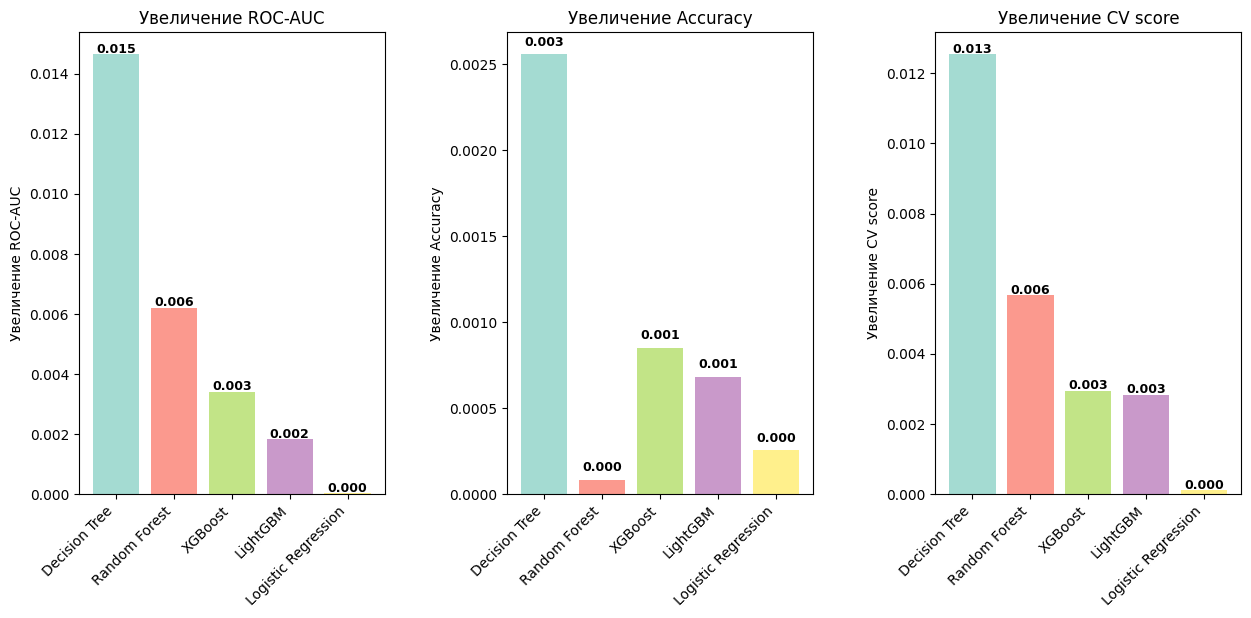

In [ ]:
fg, axs = plt.subplots(1, 3, figsize = (15, 6))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

#1. ROC-AUC
colors = plt.cm.Set3(np.linspace(0, 1, len(comparison_df)))
bars1 = axs[0].bar(range(len(comparison_df)), comparison_df['ROC improv'],  color = colors, alpha = 0.8)
axs[0].set_xticks(range(len(comparison_df)))
axs[0].set_xticklabels(comparison_df['Model'], rotation = 45, ha = 'right')
axs[0].set_ylabel('Увеличение ROC-AUC')
axs[0].set_title('Увеличение ROC-AUC')

# Добавляем значения на столбцы
for bar, value in zip(bars1, comparison_df['ROC improv']):
    axs[0].text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.00005, f'{value:.3f}', ha='center', fontweight='bold', fontsize=9)

#2. Accuracy
bars2 = axs[1].bar(range(len(comparison_df)), comparison_df['Accuracy improv'], color = colors, alpha = 0.8)
axs[1].set_xticks(range(len(comparison_df)))
axs[1].set_xticklabels(comparison_df['Model'], rotation = 45, ha = 'right')
axs[1].set_ylabel('Увеличение Accuracy')
axs[1].set_title('Увеличение Accuracy')

for bar, value in zip(bars2, comparison_df['Accuracy improv']):
  axs[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.00005, f'{value:.3f}', ha = 'center', fontweight = 'bold', fontsize = 9)

#3. CV score
bars3 = axs[2].bar(range(len(comparison_df)), comparison_df['CV score improv'], color = colors, alpha = 0.8)
axs[2].set_xticks(range(len(comparison_df)))
axs[2].set_xticklabels(comparison_df['Model'], rotation = 45, ha = 'right')
axs[2].set_ylabel('Увеличение CV score')
axs[2].set_title('Увеличение CV score')

for bar, value in zip(bars3, comparison_df['CV score improv']):
  axs[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.00005, f'{value:.3f}', ha = 'center', fontweight = 'bold', fontsize = 9)

plt.show()

Decision Tree показал прирост по каждой из метрик после оптимизации

# 3. **Ensemble методы**

Стэкинг

In [ ]:
from sklearn.ensemble import StackingClassifier

stacking_models = [
    ('dt', DecisionTreeClassifier(**opt_result['Decision Tree']['Best params'])),
    ('rf', RandomForestClassifier(**opt_result['Random Forest']['Best params'])),
    ('xgb', xgb.XGBClassifier(**opt_result['XGBoost']['Best params'])),
    ('lgb', lgb.LGBMClassifier(**opt_result['LightGBM']['Best params']))
]
meta_model = LogisticRegression(**opt_result['Logistic Regression']['Best params'])

stacking_model = StackingClassifier(
    estimators = stacking_models,
    final_estimator = meta_model,
    cv= 5,
    n_jobs = -1
)
stacking_model.fit(X_train, y_train)
stacking_proba = stacking_model.predict_proba(X_test)[:, 1]
stacking_auc = roc_auc_score(y_test, stacking_proba)
stacking_accuracy = accuracy_score(y_test, stacking_model.predict(X_test))

print(f'Stacking ROC-AUC = {stacking_auc:.3f}')
print(f'Stacking accuracy = {stacking_accuracy:.3f}')

Stacking ROC-AUC = 0.958
Stacking accuracy 0.953


Стэкинг показал небольшое увеличение метрик в сравнении с базовыми моделями (кроме LightGBM)

Блендинг

In [ ]:
blending_models = {
   'Decision Tree': DecisionTreeClassifier(**opt_result['Decision Tree']['Best params']),
   'Random Forest': RandomForestClassifier(**opt_result['Random Forest']['Best params']),
   'XGBoost':  xgb.XGBClassifier(**opt_result['XGBoost']['Best params']),
   'LightGBM': lgb.LGBMClassifier(**opt_result['LightGBM']['Best params']),
   'Logistic Regression': LogisticRegression(**opt_result['Logistic Regression']['Best params'])
}
val_blend_predictions = {}
test_blend_predictions = {}

X_train_blend, X_val_blend, y_train_blend, y_val_blend = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42, stratify = y_train)

for name in blending_models.keys():
  print(f'✅ Обучение {name}...')
  if name == 'Logistic Regression':
    X_train_blend_cur = sc.fit_transform(X_train_blend)
    X_val_blend_cur = sc.transform(X_val_blend)
    X_train_cur = X_train_scaled
    X_test_cur = X_test_scaled
  else:
    X_train_blend_cur = X_train_blend
    X_val_blend_cur = X_val_blend
    X_train_cur = X_train
    X_test_cur = X_test
  #Обучим на тренировочной выборке для блендинга и предскажем на валидационной
  blending_models[name].fit(X_train_blend_cur, y_train_blend)
  y_val_pred =  blending_models[name].predict(X_val_blend_cur)
  y_val_proba = blending_models[name].predict_proba(X_val_blend_cur)[:, 1]

  val_blend_predictions[name] = y_val_proba

  #Обучим модель на всей тренировочной выборке и предскажем на тесте
  blending_models[name].fit(X_train_cur, y_train)
  y_test_pred =  blending_models[name].predict(X_test_cur)
  y_test_proba = blending_models[name].predict_proba(X_test_cur)[:, 1]

  test_blend_predictions[name] = y_test_proba
  print('Предсказание завершено!')

#Блендинг
from scipy.optimize import differential_evolution
model_names = list(blending_models.keys())
val_pred_matrix = np.column_stack(list(val_blend_predictions.values()))
bounds = [(0, 1) for _ in range(len(model_names))] #инициализация весов (от 0 до 1)

def objective_weights(weights):
  weights = weights/weights.sum() #нормируем веса
  blend_pred = np.dot(val_pred_matrix, weights)
  return -roc_auc_score(y_val_blend, blend_pred)

blend_result = differential_evolution(objective_weights, bounds, seed = 42)
optimal_weights = blend_result.x/blend_result.x.sum() #финальная нормализация

test_pred_matrix = np.column_stack(list(test_blend_predictions.values()))
final_blend_result = np.dot(test_pred_matrix, optimal_weights)

blending_auc = roc_auc_score(y_test, final_blend_result)

print()
print(f'Blending ROC-AUC = {blending_auc:.3f}')

✅ Обучение Decision Tree...
Предсказание завершено!
✅ Обучение Random Forest...
Предсказание завершено!
✅ Обучение XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:04:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bagging_fraction" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:04:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bagging_fraction" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Предсказание завершено!
✅ Обучение LightGBM...
Предсказание завершено!
✅ Обучение Logistic Regression...
Предсказание завершено!

Blending ROC-AUC  = 0.958


Блендинг показал результат чуть лучше, чем стэкинг

# **4. Многослойный перцептрон**

Импортируем все необходимые библиотеки

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
class MLPClassifier(nn.Module):
#Инициализация архитектуры нейронной сети
  def __init__(self, input_size, hidden_sizes = [256, 128, 64, 32], dropout_rate = 0.3):
    super(MLPClassifier, self).__init__()
    layers = []
    prev_size = input_size
    for hidden_size in hidden_sizes:
      layers.append(nn.Linear(prev_size, hidden_size))
      layers.append(nn.BatchNorm1d(hidden_size))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      prev_size = hidden_size

    layers.append(nn.Linear(prev_size, 1))
    layers.append(nn.Sigmoid())

    self.networks = nn.Sequential(*layers)

  def forward(self, x):
    return self.networks(x)


In [ ]:
#Преобразование данных для нейронной сети
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

In [ ]:
#Пайплайн обучения нейронной сети
def train_mlp(model, train_loader, num_epochs = 100, learning_rate = 0.001):
  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1)

  train_losses  = []
  model.train()
  for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
      optimizer.zero_grad()
      outputs = model(batch_X)
      loss = criterion(outputs, batch_y)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

    scheduler.step()
    avg_loss = epoch_loss/len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 20 == 0:
      print(f'Epoch loss = {avg_loss:.4f}')

  return train_losses

In [ ]:
mlp_model = MLPClassifier(X_train_tensor.shape[1])

In [ ]:
train_losses = train_mlp(mlp_model, train_loader, num_epochs = 100)

Epoch loss = 0.1856
Epoch loss = 0.1811
Epoch loss = 0.1783
Epoch loss = 0.1791
Epoch loss = 0.1747


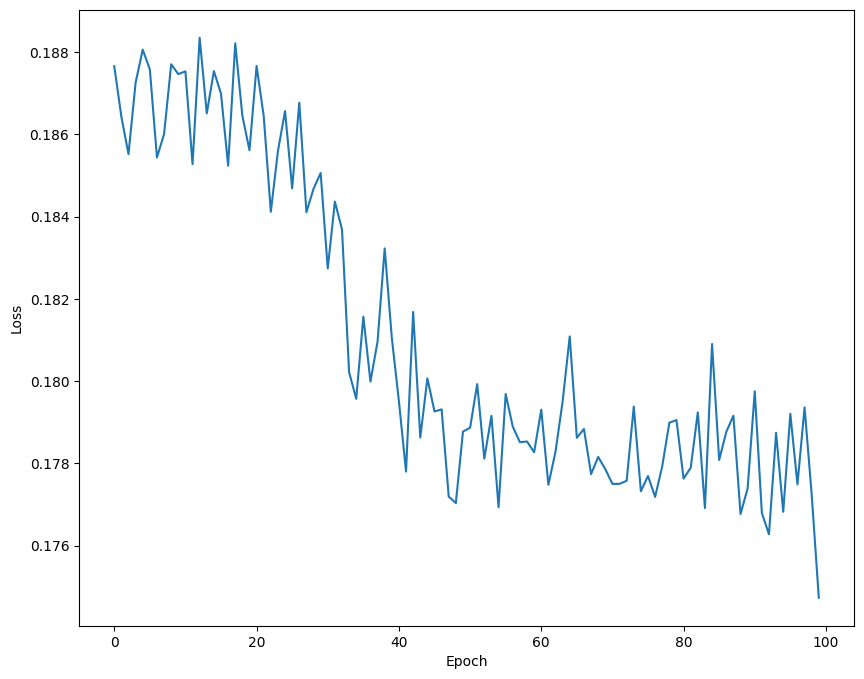

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
mlp_model.eval()
with torch.no_grad():
  mlp_pred_proba = mlp_model(X_test_tensor).numpy().flatten()

mlp_auc_score = roc_auc_score(y_test_tensor, mlp_pred_proba)
print(f'MLP ROC-AUC = {mlp_auc_score:.4f}')

MLP ROC-AUC = 0.9310


Сравним результаты всех моделей

In [ ]:
list(comparison_df['ROC after'].values)

[np.float64(0.9233328154308741),
 np.float64(0.9377761030280627),
 np.float64(0.9573397791354362),
 np.float64(0.9586361425672367),
 np.float64(0.8968509744602652)]

⚡ Сравнение моделей
              Model  ROC-AUC           Type
           LightGBM   0.9586 Классически ML
           Blending   0.9582 Ensemble метод
           Stacking   0.9576 Ensemble метод
            XGBoost   0.9573 Классически ML
      Random Forest   0.9378 Классически ML
                MLP   0.9310      MLP метод
      Decision Tree   0.9233 Классически ML
Logistic Regression   0.8969 Классически ML


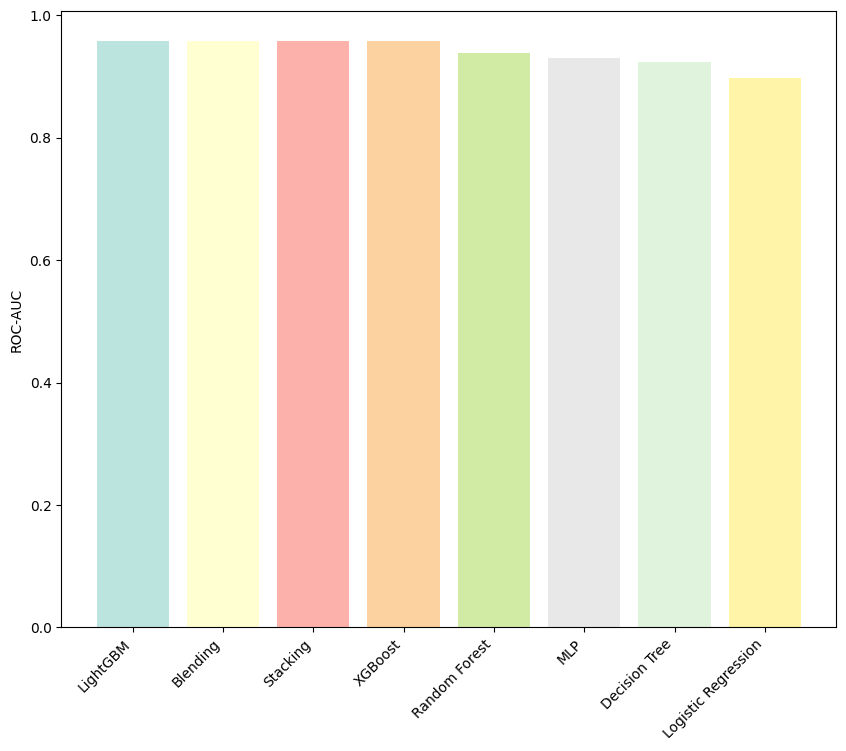

In [ ]:
final_comparison_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM', 'Logistic Regression', 'Stacking', 'Blending', 'MLP'],
    'ROC-AUC': [*list(comparison_df['ROC after'].values), stacking_auc, blending_auc, mlp_auc_score],
    'Type': ['Классически ML', 'Классически ML', 'Классически ML', 'Классически ML', 'Классически ML', 'Ensemble метод', 'Ensemble метод', 'MLP метод']
})
final_comparison_df = final_comparison_df.sort_values('ROC-AUC', ascending = False)

print('⚡ Сравнение моделей')
print(final_comparison_df.round(4).to_string(index = False))

colors = plt.cm.Set3(np.linspace(0, 1, len(final_comparison_df)))
plt.figure(figsize = (10, 8))
plt.bar(range(len(final_comparison_df)), final_comparison_df['ROC-AUC'], color = colors, alpha = 0.6)
plt.xticks(range(len(final_comparison_df)), final_comparison_df['Model'], rotation = 45, ha = 'right')
plt.ylabel('ROC-AUC')
plt.show()

# **Выводы**

Результаты показывают, что базовые модели машинного обучения остаются конкурентноспособными для задач на табличных данных. Градиентный бустинг в совокупности с ансамблевыми методами, показал очень хороший результат и может составить конкуренцию простым нейронным сетям.